# Temperature Forecast Project
Problem Statement:
Data Set Information:

This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea. This data consists of summer data from 2013 to 2017. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.

Attribute Information:

For more information, read [Cho et al, 2020].

station - used weather station number: 1 to 25
Date - Present day: yyyy-mm-dd ('2013-06-30' to '2017-08-30')
Present_Tmax - Maximum air temperature between 0 and 21 h on the present day (Â°C): 20 to 37.6
Present_Tmin - Minimum air temperature between 0 and 21 h on the present day (Â°C): 11.3 to 29.9
LDAPS_RHmin - LDAPS model forecast of next-day minimum relative humidity (%): 19.8 to 98.5
LDAPS_RHmax - LDAPS model forecast of next-day maximum relative humidity (%): 58.9 to 100
LDAPS_Tmax_lapse - LDAPS model forecast of next-day maximum air temperature applied lapse rate (Â°C): 17.6 to 38.5
LDAPS_Tmin_lapse - LDAPS model forecast of next-day minimum air temperature applied lapse rate (Â°C): 14.3 to 29.6
LDAPS_WS - LDAPS model forecast of next-day average wind speed (m/s): 2.9 to 21.9
LDAPS_LH - LDAPS model forecast of next-day average latent heat flux (W/m2): -13.6 to 213.4
LDAPS_CC1 - LDAPS model forecast of next-day 1st 6-hour split average cloud cover (0-5 h) (%): 0 to 0.97
LDAPS_CC2 - LDAPS model forecast of next-day 2nd 6-hour split average cloud cover (6-11 h) (%): 0 to 0.97
LDAPS_CC3 - LDAPS model forecast of next-day 3rd 6-hour split average cloud cover (12-17 h) (%): 0 to 0.98
LDAPS_CC4 - LDAPS model forecast of next-day 4th 6-hour split average cloud cover (18-23 h) (%): 0 to 0.97
LDAPS_PPT1 - LDAPS model forecast of next-day 1st 6-hour split average precipitation (0-5 h) (%): 0 to 23.7
LDAPS_PPT2 - LDAPS model forecast of next-day 2nd 6-hour split average precipitation (6-11 h) (%): 0 to 21.6
LDAPS_PPT3 - LDAPS model forecast of next-day 3rd 6-hour split average precipitation (12-17 h) (%): 0 to 15.8
LDAPS_PPT4 - LDAPS model forecast of next-day 4th 6-hour split average precipitation (18-23 h) (%): 0 to 16.7
lat - Latitude (Â°): 37.456 to 37.645
lon - Longitude (Â°): 126.826 to 127.135
DEM - Elevation (m): 12.4 to 212.3
Slope - Slope (Â°): 0.1 to 5.2
Solar radiation - Daily incoming solar radiation (wh/m2): 4329.5 to 5992.9
Next_Tmax - The next-day maximum air temperature (Â°C): 17.4 to 38.9
Next_Tmin - The next-day minimum air temperature (Â°C): 11.3 to 29.8T

In [58]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from scipy.stats import zscore
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
df=pd.read_csv('temp.csv')
df

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,30-06-2013,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.000000,0.000000,0.000000,37.6046,126.991,212.3350,2.785000,5992.895996,29.1,21.2
1,2.0,30-06-2013,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.000000,0.000000,0.000000,37.6046,127.032,44.7624,0.514100,5869.312500,30.5,22.5
2,3.0,30-06-2013,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.000000,0.000000,0.000000,37.5776,127.058,33.3068,0.266100,5863.555664,31.1,23.9
3,4.0,30-06-2013,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.000000,0.000000,0.000000,37.6450,127.022,45.7160,2.534800,5856.964844,31.7,24.3
4,5.0,30-06-2013,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.000000,0.000000,0.000000,37.5507,127.135,35.0380,0.505500,5859.552246,31.2,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,23.0,30-08-2017,23.3,17.1,26.741310,78.869858,26.352081,18.775678,6.148918,72.058294,...,0.000000,0.000000,0.000000,37.5372,126.891,15.5876,0.155400,4443.313965,28.3,18.1
7748,24.0,30-08-2017,23.3,17.7,24.040634,77.294975,27.010193,18.733519,6.542819,47.241457,...,0.000000,0.000000,0.000000,37.5237,126.909,17.2956,0.222300,4438.373535,28.6,18.8
7749,25.0,30-08-2017,23.2,17.4,22.933014,77.243744,27.939516,18.522965,7.289264,9.090034,...,0.000000,0.000000,0.000000,37.5237,126.970,19.5844,0.271300,4451.345215,27.8,17.4
7750,NaN,NaN,20.0,11.3,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,...,0.000000,0.000000,0.000000,37.4562,126.826,12.3700,0.098475,4329.520508,17.4,11.3


# Exploratory Data Analysis

In [3]:
df.shape

(7752, 25)

from the shape method it is displaying that our dataset is having 7752 rows and 25 columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


from the info method we can say that our dataset is having only numerical value except Date column we need to deal with it  and also our tafet label is numerical type then we have to build best ML Regression model for it .

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
station,7750.0,13.000000,7.211568,1.000000,7.000000,13.000000,19.000000,25.000000
Present_Tmax,7682.0,29.768211,2.969999,20.000000,27.800000,29.900000,32.000000,37.600000
Present_Tmin,7682.0,23.225059,2.413961,11.300000,21.700000,23.400000,24.900000,29.900000
LDAPS_RHmin,7677.0,56.759372,14.668111,19.794666,45.963543,55.039024,67.190056,98.524734
LDAPS_RHmax,7677.0,88.374804,7.192004,58.936283,84.222862,89.793480,93.743629,100.000153
LDAPS_Tmax_lapse,7677.0,29.613447,2.947191,17.624954,27.673499,29.703426,31.710450,38.542255
LDAPS_Tmin_lapse,7677.0,23.512589,2.345347,14.272646,22.089739,23.760199,25.152909,29.619342
LDAPS_WS,7677.0,7.097875,2.183836,2.882580,5.678705,6.547470,8.032276,21.857621
LDAPS_LH,7677.0,62.505019,33.730589,-13.603212,37.266753,56.865482,84.223616,213.414006
LDAPS_CC1,7677.0,0.368774,0.262458,0.000000,0.146654,0.315697,0.575489,0.967277


from above Describe . Transpose method we can say that many columns has missing value and we must dealt with this missing value before building the model.

In [6]:
df.isnull().sum()

station              2
Date                 2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
dtype: int64

from the above plot we can say there are so many columns having missing value

# Data Preprocessing

In [7]:
df['Date']=pd.to_datetime(df['Date'])
df['Day']=df['Date'].apply(lambda x:x.day)
df['Month']=df['Date'].apply(lambda x:x.month)
df['Year']=df['Date'].apply(lambda x:x.year)
df.drop('Date', axis=1, inplace=True)
df.head()


,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Day,Month,Year
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,...,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2,30.0,6.0,2013.0
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,...,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5,30.0,6.0,2013.0
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,...,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9,30.0,6.0,2013.0
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,...,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3,30.0,6.0,2013.0
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,...,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5,30.0,6.0,2013.0


Here we have removed the object datatype "Date" column and separated the "Date" column into three different columns namely day - month - year with the help of pandas Datetime option.

In [8]:
!pip install reverse_geocoder
import reverse_geocoder as rg
import pprint

In [9]:
geodata=[]
def reverse_geocoordinates(coordinates):
    result = rg.search(coordinates)
    return (result)

if __name__=="__main__":
    coordinates = list(zip(df['lat'], df['lon']))
    data = reverse_geocoordinates(coordinates)
    geodata.append(data)

geo_names = pd.DataFrame(geodata).transpose()
print(geo_names)

Loading formatted geocoded file...
                                                      0
0     {'lat': '37.566', 'lon': '126.9784', 'name': '...
1     {'lat': '37.566', 'lon': '126.9784', 'name': '...
2     {'lat': '37.566', 'lon': '126.9784', 'name': '...
3     {'lat': '37.566', 'lon': '126.9784', 'name': '...
4     {'lat': '37.5986', 'lon': '127.1394', 'name': ...
...                                                 ...
7747  {'lat': '37.47722', 'lon': '126.86639', 'name'...
7748  {'lat': '37.47722', 'lon': '126.86639', 'name'...
7749  {'lat': '37.566', 'lon': '126.9784', 'name': '...
7750  {'lat': '37.47722', 'lon': '126.86639', 'name'...
7751  {'lat': '37.5986', 'lon': '127.1394', 'name': ...

[7752 rows x 1 columns]


So here I have acquired the state and city names corresponding to it's latitude and longitude data however we will need to incorporate it properly inside our dataset and format it.

In [10]:
df['State']=geo_names[0].apply(lambda x:x.get('admin1'))
df['City']=geo_names[0].apply(lambda x:x.get('name'))
df.drop(['lat','lon'], axis=1, inplace=True)
df

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Day,Month,Year,State,City
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,...,212.3350,2.785000,5992.895996,29.1,21.2,30.0,6.0,2013.0,Seoul,Seoul
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,...,44.7624,0.514100,5869.312500,30.5,22.5,30.0,6.0,2013.0,Seoul,Seoul
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,...,33.3068,0.266100,5863.555664,31.1,23.9,30.0,6.0,2013.0,Seoul,Seoul
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,...,45.7160,2.534800,5856.964844,31.7,24.3,30.0,6.0,2013.0,Seoul,Seoul
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,...,35.0380,0.505500,5859.552246,31.2,22.5,30.0,6.0,2013.0,Gyeonggi-do,Guri-si
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,23.0,23.3,17.1,26.741310,78.869858,26.352081,18.775678,6.148918,72.058294,0.030034,...,15.5876,0.155400,4443.313965,28.3,18.1,30.0,8.0,2017.0,Gyeonggi-do,Kwangmyong
7748,24.0,23.3,17.7,24.040634,77.294975,27.010193,18.733519,6.542819,47.241457,0.035874,...,17.2956,0.222300,4438.373535,28.6,18.8,30.0,8.0,2017.0,Gyeonggi-do,Kwangmyong
7749,25.0,23.2,17.4,22.933014,77.243744,27.939516,18.522965,7.289264,9.090034,0.048954,...,19.5844,0.271300,4451.345215,27.8,17.4,30.0,8.0,2017.0,Seoul,Seoul
7750,NaN,20.0,11.3,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,...,12.3700,0.098475,4329.520508,17.4,11.3,NaN,NaN,NaN,Gyeonggi-do,Kwangmyong


I was successfully able to create 2 new columns for state and city in our dataframe corresponding to their lattude and longitude locations. Since the information was achieved I have dropped the original columns "lat" and "lon" to avoid duplicate data columns.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Present_Tmax      7682 non-null   float64
 2   Present_Tmin      7682 non-null   float64
 3   LDAPS_RHmin       7677 non-null   float64
 4   LDAPS_RHmax       7677 non-null   float64
 5   LDAPS_Tmax_lapse  7677 non-null   float64
 6   LDAPS_Tmin_lapse  7677 non-null   float64
 7   LDAPS_WS          7677 non-null   float64
 8   LDAPS_LH          7677 non-null   float64
 9   LDAPS_CC1         7677 non-null   float64
 10  LDAPS_CC2         7677 non-null   float64
 11  LDAPS_CC3         7677 non-null   float64
 12  LDAPS_CC4         7677 non-null   float64
 13  LDAPS_PPT1        7677 non-null   float64
 14  LDAPS_PPT2        7677 non-null   float64
 15  LDAPS_PPT3        7677 non-null   float64
 16  LDAPS_PPT4        7677 non-null   float64


In [12]:
df.nunique().to_frame()


,0
station,25
Present_Tmax,167
Present_Tmin,155
LDAPS_RHmin,7672
LDAPS_RHmax,7664
LDAPS_Tmax_lapse,7675
LDAPS_Tmin_lapse,7675
LDAPS_WS,7675
LDAPS_LH,7675
LDAPS_CC1,7569


In [13]:
df.isnull().sum()

station              2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
Day                  2
Month                2
Year                 2
State                0
City                 0
dtype: int64

from the help of isna method with sum functionn we find the missing values and here in this dataset we can see that there almost every column has some missing values that need to be dealt .

In [14]:
print('missing value percentage')

for col in df:
    percentage= np.round(df[col].isnull().sum()/df.shape[0]*100,3)
    print(col, ":".format(), percentage, '%')
    

missing value percentage
station : 0.026 %
Present_Tmax : 0.903 %
Present_Tmin : 0.903 %
LDAPS_RHmin : 0.967 %
LDAPS_RHmax : 0.967 %
LDAPS_Tmax_lapse : 0.967 %
LDAPS_Tmin_lapse : 0.967 %
LDAPS_WS : 0.967 %
LDAPS_LH : 0.967 %
LDAPS_CC1 : 0.967 %
LDAPS_CC2 : 0.967 %
LDAPS_CC3 : 0.967 %
LDAPS_CC4 : 0.967 %
LDAPS_PPT1 : 0.967 %
LDAPS_PPT2 : 0.967 %
LDAPS_PPT3 : 0.967 %
LDAPS_PPT4 : 0.967 %
DEM : 0.0 %
Slope : 0.0 %
Solar radiation : 0.0 %
Next_Tmax : 0.348 %
Next_Tmin : 0.348 %
Day : 0.026 %
Month : 0.026 %
Year : 0.026 %
State : 0.0 %
City : 0.0 %


In [15]:
print('we had {} rows and {} columns before droping the null values columns.'.format(df.shape[0],df.shape[1]))
df.dropna(inplace=True)
print('we hav {} rows and {} columns after dropping the null values columns'.format(df.shape[0],df.shape[1]))

we had 7752 rows and 27 columns before droping the null values columns.
we hav 7588 rows and 27 columns after dropping the null values columns


In [16]:
df.isnull().sum()

station             0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
Day                 0
Month               0
Year                0
State               0
City                0
dtype: int64

In [17]:
object_datatype=[]
for x in df.dtypes.index:
    if df.dtypes[x]=='O':
        object_datatype.append(x)
print(object_datatype)
        
        

['State', 'City']


we have dropped some of rows having null value since we have lots of rows we can afford this loss .

# Visualization

In [18]:
col=['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'DEM', 'Slope',
       'Solar radiation', 'Next_Tmax', 'Next_Tmin', 'Day', 'Month', 'Year',
       'State', 'City']
print(col)

['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin', 'Day', 'Month', 'Year', 'State', 'City']


storing all columns name into single variable name as col maybe they can come in use.

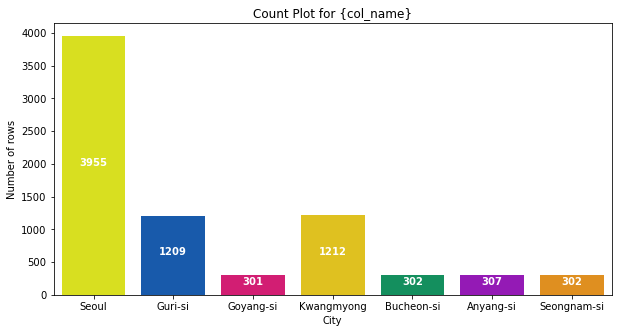

In [19]:
try:
    plt.figure(figsize=(10,5))
    col_name='City'
    values=df[col_name].value_counts()
    ax=sns.countplot(df[col_name],palette="prism")
    index=0
    
    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
        
        
       
        
    plt.title("Count Plot for {col_name}")
    plt.ylabel(f"Number of rows")
    plt.show()
    
except Exception as e:
    pass
        

from the above plot we can see that the city Seoul is having more than any other city

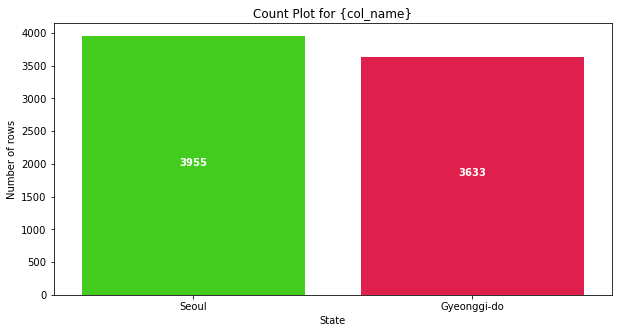

In [20]:
try:
    plt.figure(figsize=(10,5))
    col_name='State'
    values=df[col_name].value_counts()
    ax=sns.countplot(df[col_name],palette="prism")
    index=0
    
    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
        
        
       
        
    plt.title("Count Plot for {col_name}")
    plt.ylabel(f"Number of rows")
    plt.show()
    
except Exception as e:
    pass

from the above plot we can see that more people aref from Seoul than Gyeonggi-do.

Countplot for State column:->


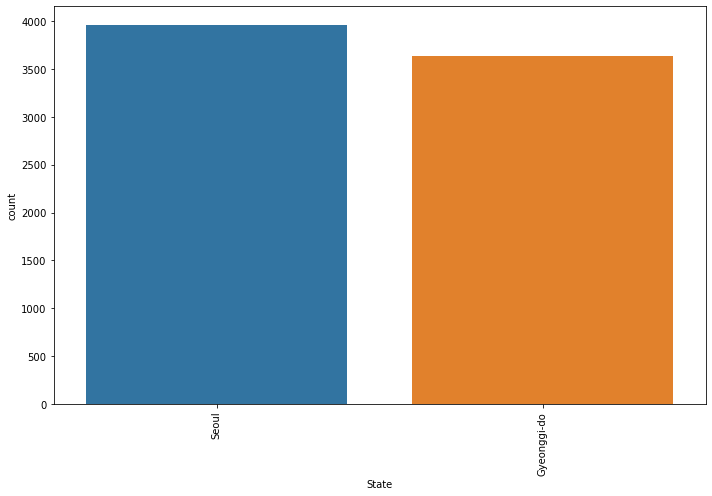

Countplot for Year column:->


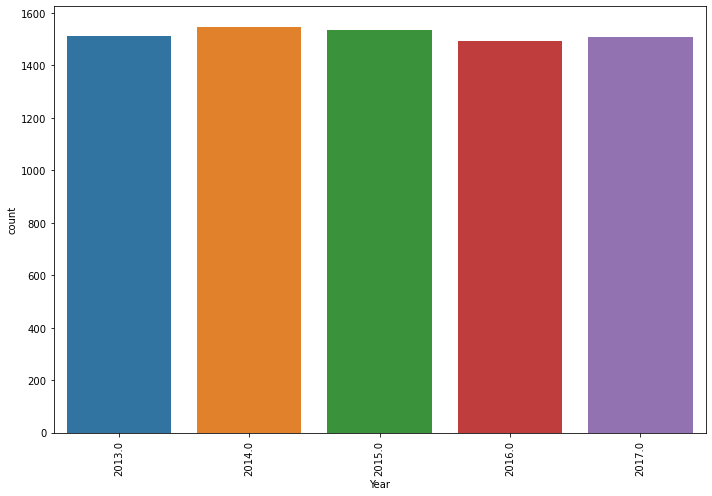

Countplot for City column:->


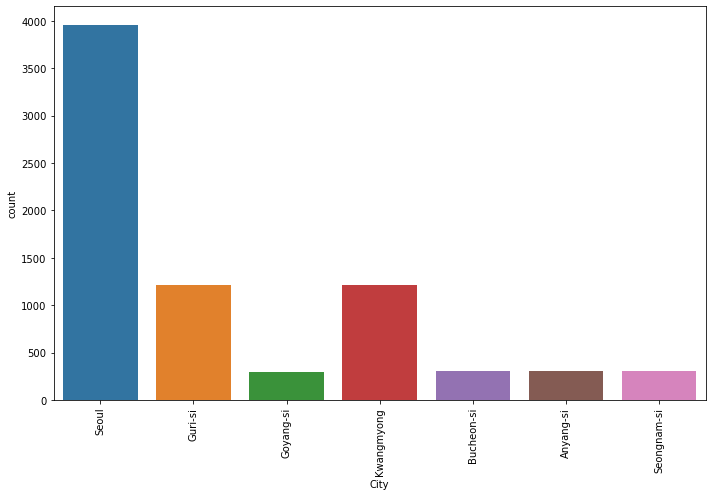

Countplot for Month column:->


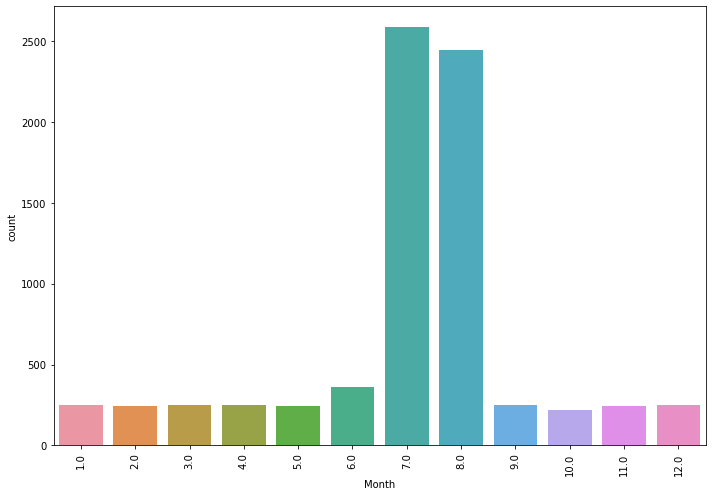

Countplot for Day column:->


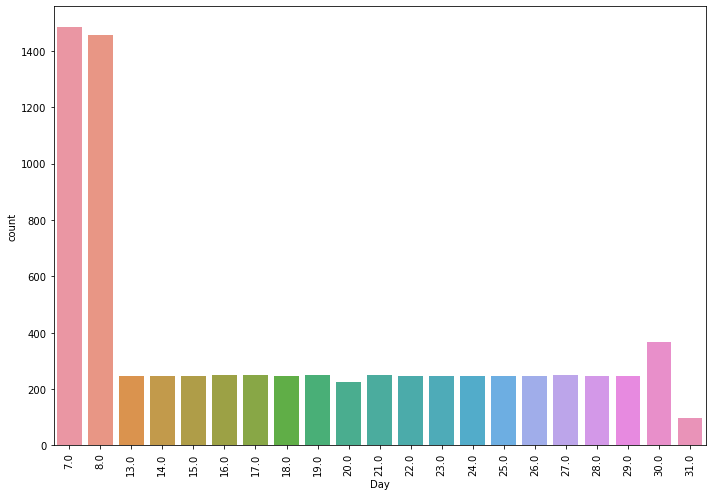

Countplot for station column:->


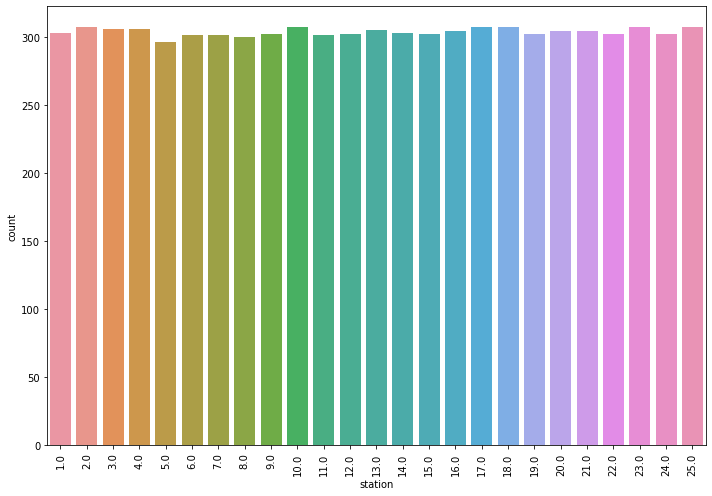

Countplot for DEM column:->


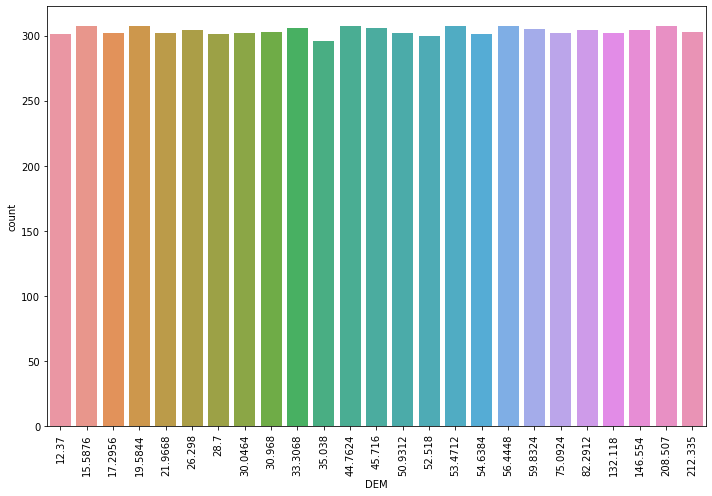

Countplot for Slope column:->


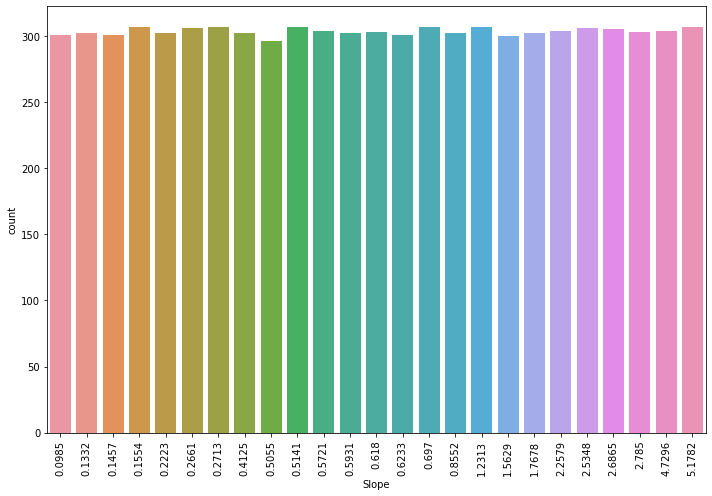

In [21]:
def generate_countplot(x):
    plt.figure(figsize=(10,7))
    sns.countplot(x)
    plt.xticks(rotation=90)
    plt.tight_layout()
    return plt.show()

col1 = ['State', 'Year', 'City', 'Month', 'Day', 'station', 'DEM', 'Slope']

for i in df[col1]:
    print("Countplot for {} column:->".format(i))
    generate_countplot(df[i])

Columns with less than 30 unique values:

State(2) shows values for Seoul is slightly higher than Gyeonggi-do province
Year(5) shows that almost all year data points have equal coverage
City(7) shows that Seoul has the highest number amongst all the other categories
Month(12) shows a very high peak in data for months July and August
Day(21) shows a very high peak in data for days 7 and 8 of a month
station(25) also shows almost equal data coverage for all it's unique values
DEM(25) has almost equal data coverage for all it's unique values
Slope(27) again shows almost equal data coverage for all it's unique values

In [22]:
col2 = [x for x in col if x not in col1]
print(col2)

['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'Solar radiation', 'Next_Tmax', 'Next_Tmin']


Scatter plot for Present_Tmax column with respect to the rows covered ->


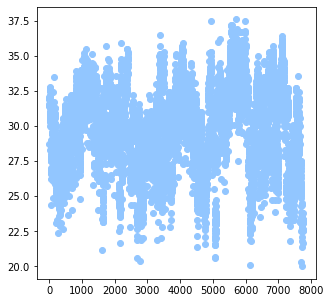

Scatter plot for Present_Tmin column with respect to the rows covered ->


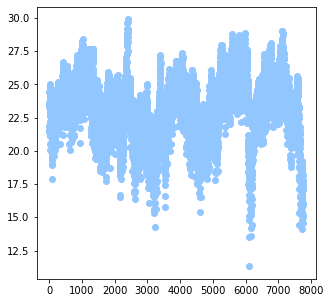

Scatter plot for LDAPS_RHmin column with respect to the rows covered ->


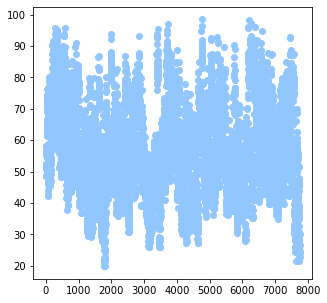

Scatter plot for LDAPS_RHmax column with respect to the rows covered ->


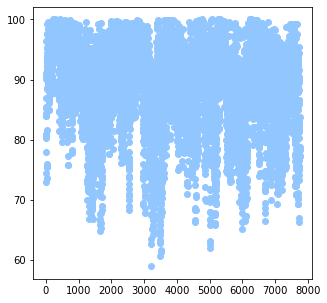

Scatter plot for LDAPS_Tmax_lapse column with respect to the rows covered ->


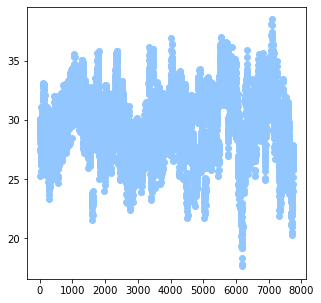

Scatter plot for LDAPS_Tmin_lapse column with respect to the rows covered ->


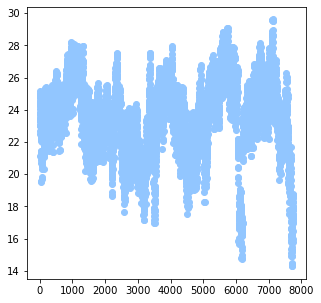

Scatter plot for LDAPS_WS column with respect to the rows covered ->


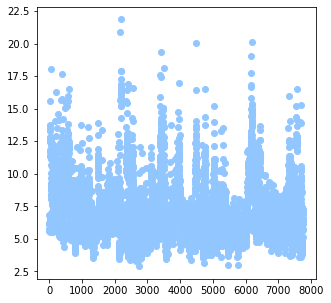

Scatter plot for LDAPS_LH column with respect to the rows covered ->


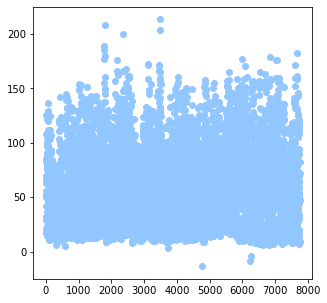

Scatter plot for LDAPS_CC1 column with respect to the rows covered ->


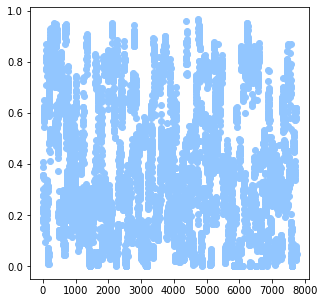

Scatter plot for LDAPS_CC2 column with respect to the rows covered ->


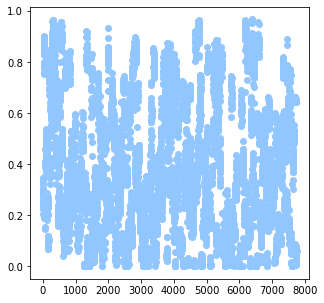

Scatter plot for LDAPS_CC3 column with respect to the rows covered ->


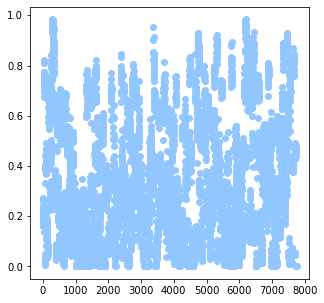

Scatter plot for LDAPS_CC4 column with respect to the rows covered ->


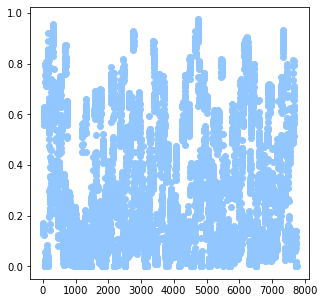

Scatter plot for LDAPS_PPT1 column with respect to the rows covered ->


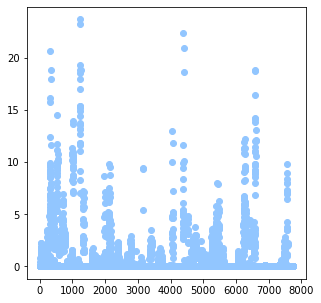

Scatter plot for LDAPS_PPT2 column with respect to the rows covered ->


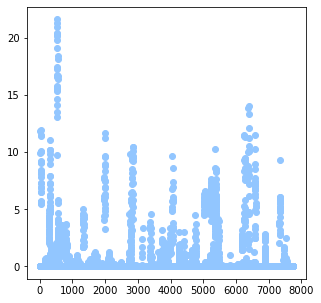

Scatter plot for LDAPS_PPT3 column with respect to the rows covered ->


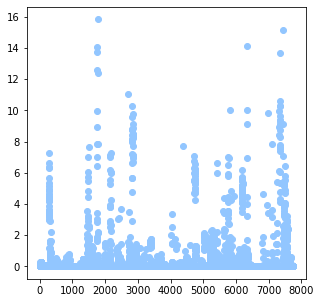

Scatter plot for LDAPS_PPT4 column with respect to the rows covered ->


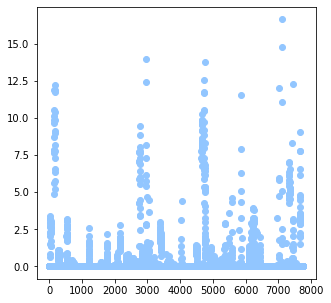

Scatter plot for Solar radiation column with respect to the rows covered ->


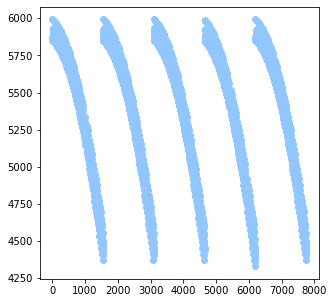

Scatter plot for Next_Tmax column with respect to the rows covered ->


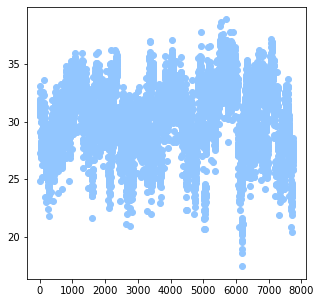

Scatter plot for Next_Tmin column with respect to the rows covered ->


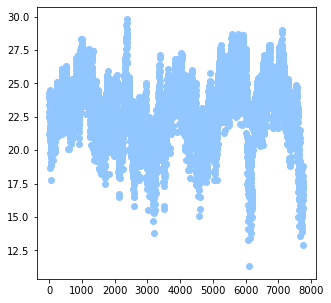

In [23]:
plt.style.use('seaborn-pastel')

for j in df[col2]:
    plt.figure(figsize=(5,5))
    print(f"Scatter plot for {j} column with respect to the rows covered ->")
    plt.scatter(df.index, df[j])
    plt.show()

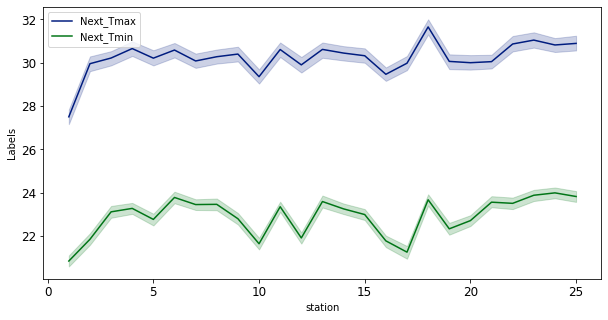

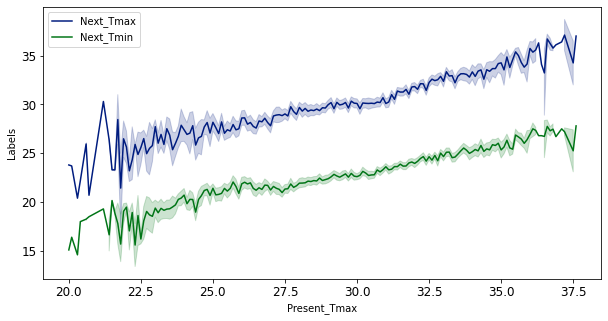

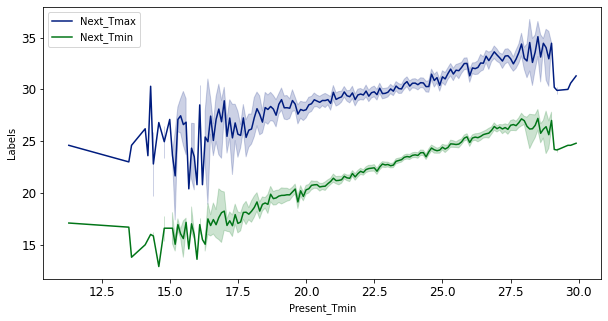

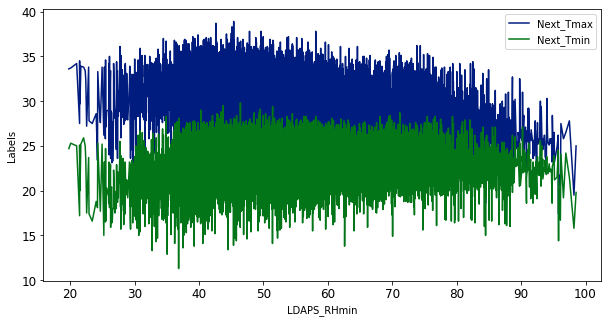

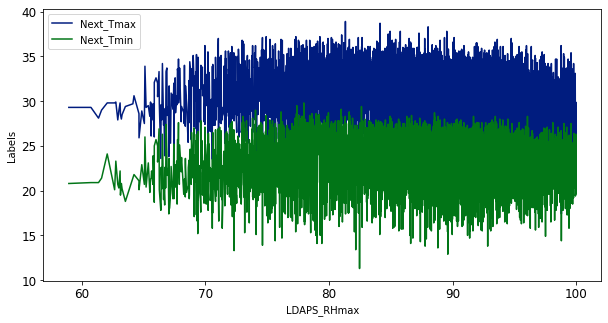

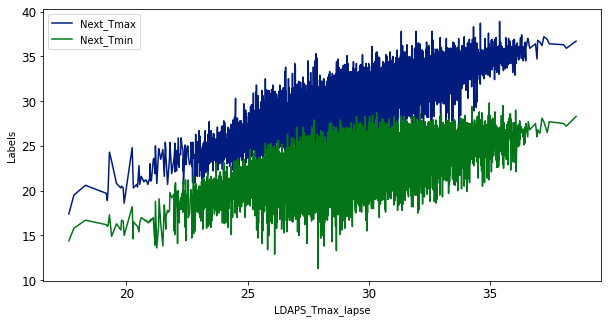

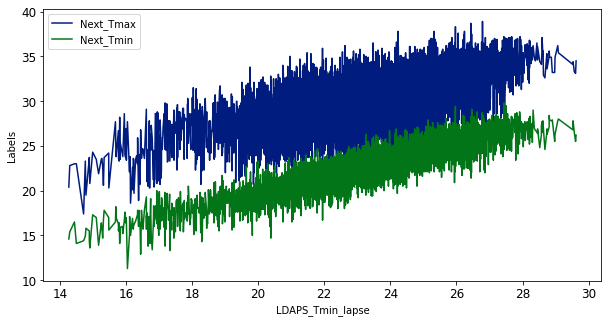

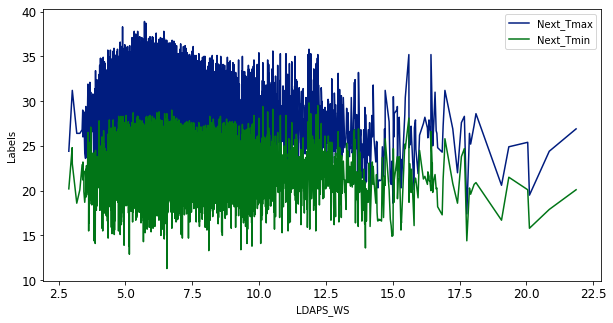

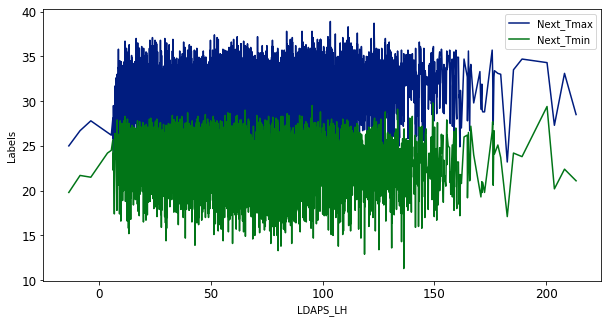

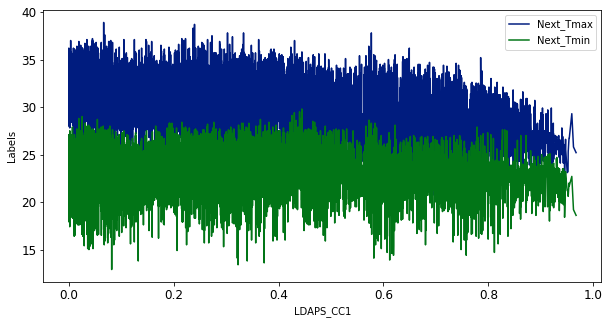

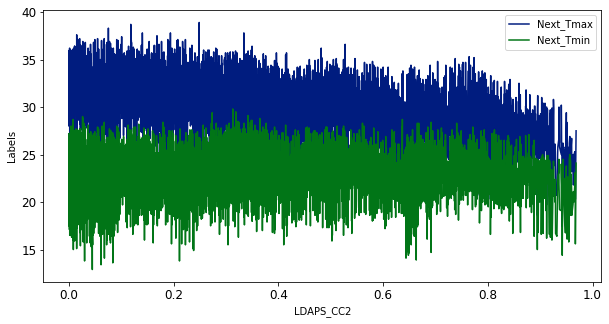

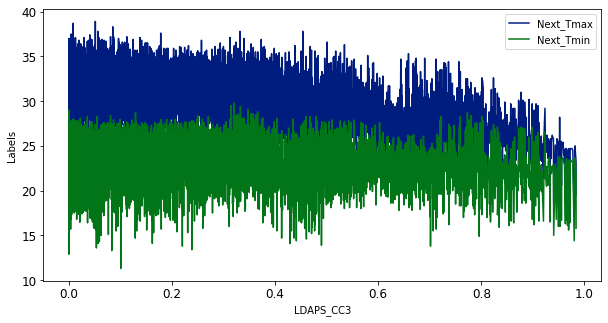

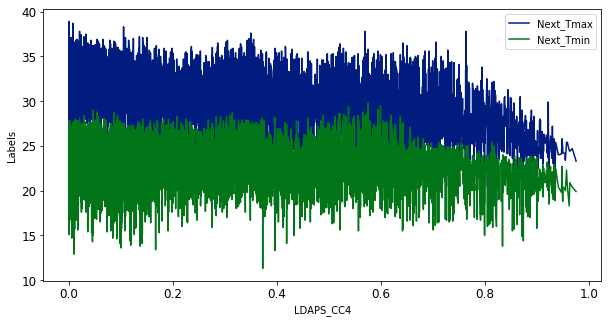

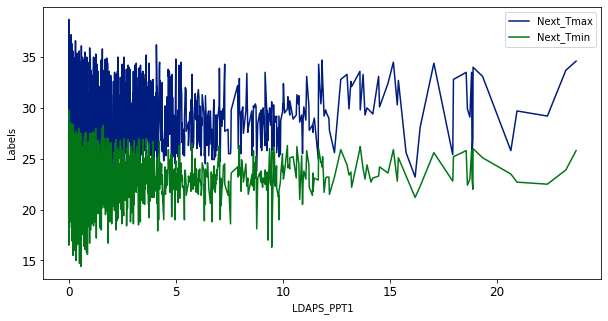

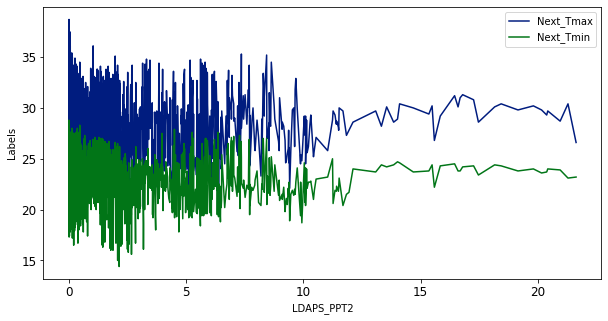

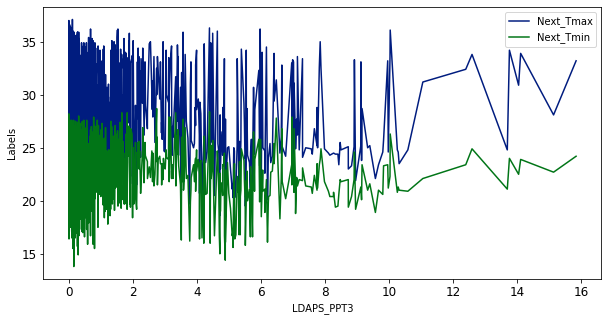

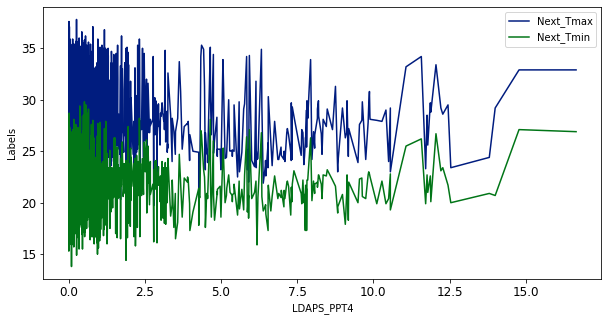

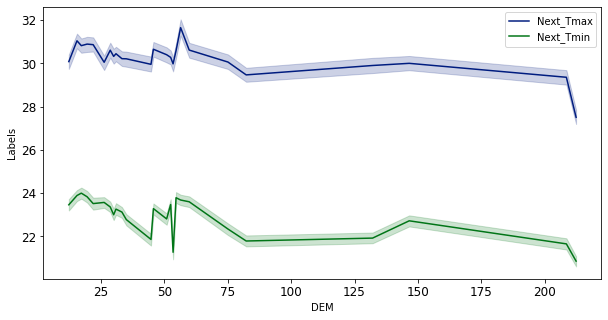

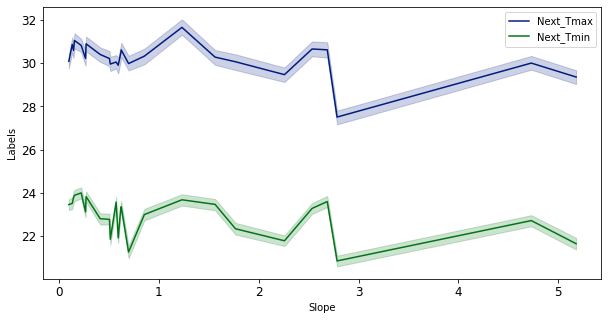

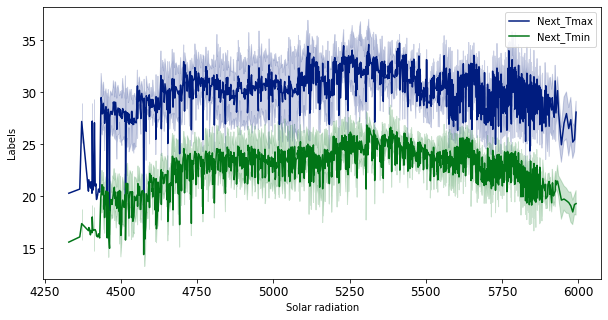

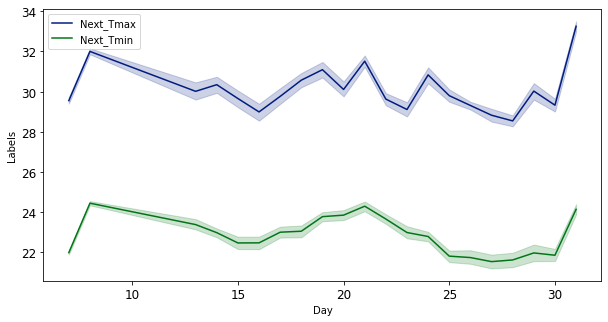

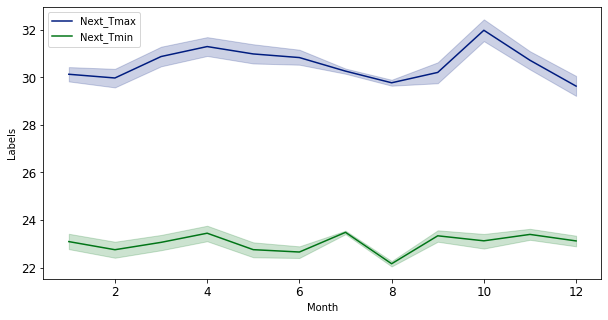

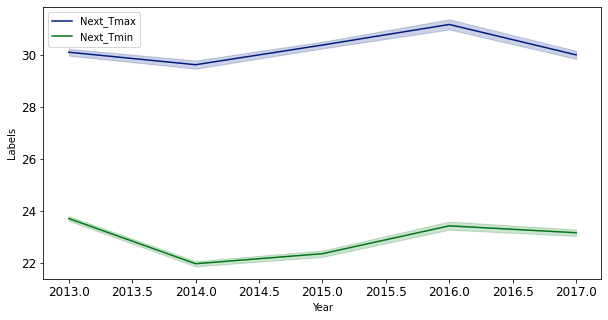

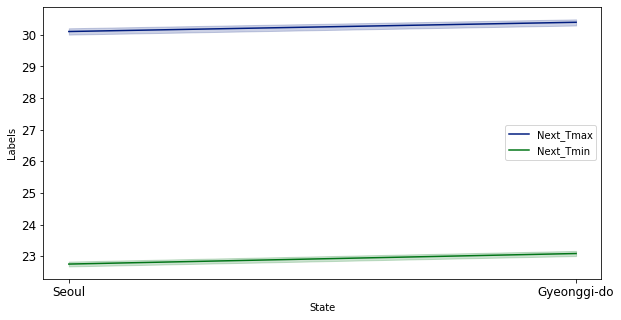

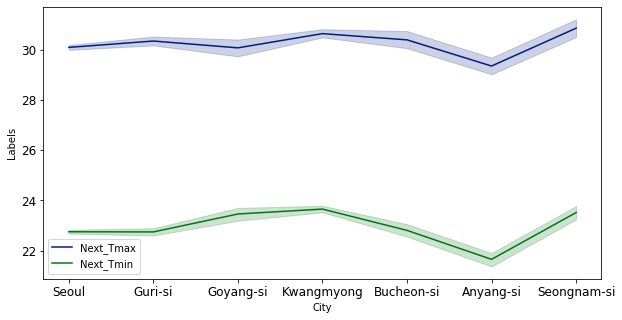

In [24]:
feature_columns = ['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 
                   'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 
            'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'DEM', 'Slope', 'Solar radiation', 'Day', 
                   'Month', 'Year', 'State', 'City']

label_columns = ['Next_Tmax', 'Next_Tmin']

plt.style.use('seaborn-dark-palette')

for z in df[feature_columns]:
    plt.figure(figsize=(10,5))
    sns.lineplot(x=df[z],y=label_columns[0], data=df )
    sns.lineplot(x=df[z], y=label_columns[1], data=df)
    plt.ylabel('Labels')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(['Next_Tmax','Next_Tmin'])
    plt.show()



from this line plot method we are able to look how our feature values are disdributed with our both labels.

In [25]:
oe=OrdinalEncoder()
col=['State', 'City']
for i in col:
    df[i]=oe.fit_transform(df[i].values.reshape(-1,1))
    

In [26]:
df

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Day,Month,Year,State,City
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,...,212.3350,2.7850,5992.895996,29.1,21.2,30.0,6.0,2013.0,1.0,6.0
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,...,44.7624,0.5141,5869.312500,30.5,22.5,30.0,6.0,2013.0,1.0,6.0
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,...,33.3068,0.2661,5863.555664,31.1,23.9,30.0,6.0,2013.0,1.0,6.0
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,...,45.7160,2.5348,5856.964844,31.7,24.3,30.0,6.0,2013.0,1.0,6.0
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,...,35.0380,0.5055,5859.552246,31.2,22.5,30.0,6.0,2013.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7745,21.0,23.1,17.8,24.688997,78.261383,27.812697,18.303014,6.603253,9.614074,0.052902,...,26.2980,0.5721,4456.024414,27.6,17.7,30.0,8.0,2017.0,1.0,6.0
7746,22.0,22.5,17.4,30.094858,83.690018,26.704905,17.814038,5.768083,82.146707,0.066461,...,21.9668,0.1332,4441.803711,28.0,17.1,30.0,8.0,2017.0,0.0,5.0
7747,23.0,23.3,17.1,26.741310,78.869858,26.352081,18.775678,6.148918,72.058294,0.030034,...,15.5876,0.1554,4443.313965,28.3,18.1,30.0,8.0,2017.0,0.0,4.0
7748,24.0,23.3,17.7,24.040634,77.294975,27.010193,18.733519,6.542819,47.241457,0.035874,...,17.2956,0.2223,4438.373535,28.6,18.8,30.0,8.0,2017.0,0.0,4.0


we have Encoded object datatype to numerical datatype

In [27]:
df.dtypes

station             float64
Present_Tmax        float64
Present_Tmin        float64
LDAPS_RHmin         float64
LDAPS_RHmax         float64
LDAPS_Tmax_lapse    float64
LDAPS_Tmin_lapse    float64
LDAPS_WS            float64
LDAPS_LH            float64
LDAPS_CC1           float64
LDAPS_CC2           float64
LDAPS_CC3           float64
LDAPS_CC4           float64
LDAPS_PPT1          float64
LDAPS_PPT2          float64
LDAPS_PPT3          float64
LDAPS_PPT4          float64
DEM                 float64
Slope               float64
Solar radiation     float64
Next_Tmax           float64
Next_Tmin           float64
Day                 float64
Month               float64
Year                float64
State               float64
City                float64
dtype: object

Great, all the data present in our dataset are in the form of numerical value.

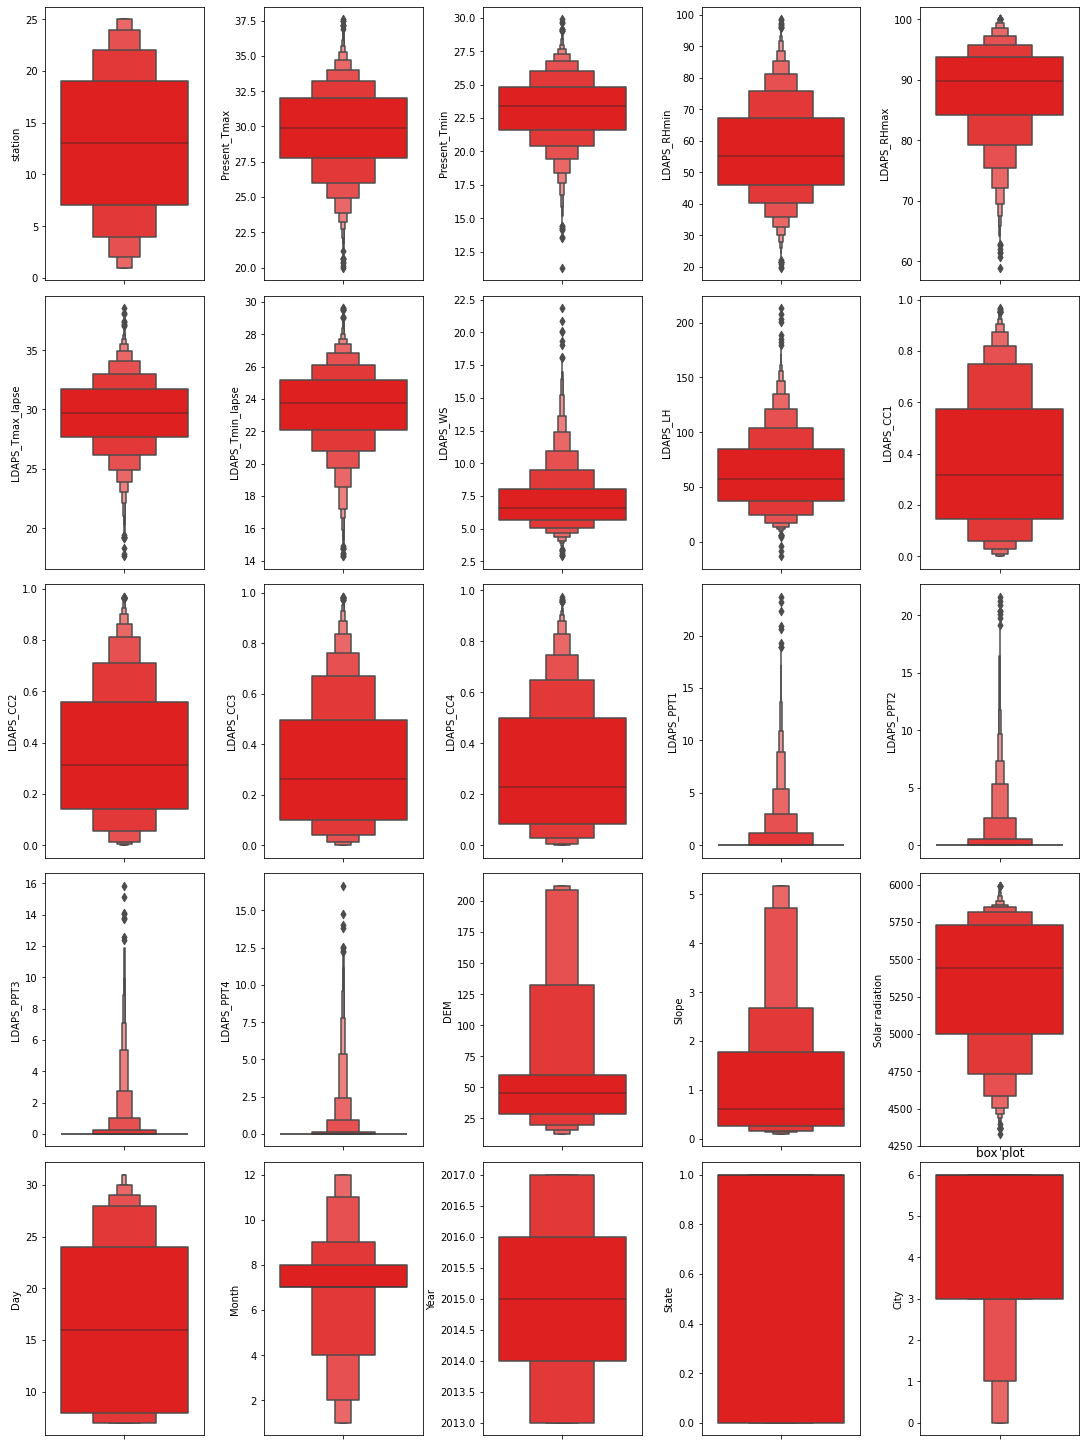

In [28]:
plt.style.use('fast')
fig, ax=plt.subplots(ncols=5, nrows=5,figsize=(15,20))
index=0
ax=ax.flatten()
for col, value in df[feature_columns].items():
    sns.boxenplot(y=col, data=df, ax=ax[index], color='Red')
    index += 1
plt.tight_layout(pad=.4, w_pad=.4, h_pad=1)
plt.title('box plot')
plt.show()
    

from the above boxen plot we can see that we have many columns containing outliers we need to deal with them.

In [29]:
df.skew()

station            -0.004178
Present_Tmax       -0.257069
Present_Tmin       -0.353822
LDAPS_RHmin         0.301396
LDAPS_RHmax        -0.845264
LDAPS_Tmax_lapse   -0.222349
LDAPS_Tmin_lapse   -0.574035
LDAPS_WS            1.553926
LDAPS_LH            0.662971
LDAPS_CC1           0.456716
LDAPS_CC2           0.473929
LDAPS_CC3           0.639649
LDAPS_CC4           0.663815
LDAPS_PPT1          5.305906
LDAPS_PPT2          5.710360
LDAPS_PPT3          6.356670
LDAPS_PPT4          6.681256
DEM                 1.721617
Slope               1.559050
Solar radiation    -0.524325
Next_Tmax          -0.334842
Next_Tmin          -0.393662
Day                 0.245563
Month              -0.703092
Year                0.013575
State              -0.084964
City               -0.973089
dtype: float64

from the above skew method we can see that most of the columns skewness is in the acceptable range that is +/-5 and only few are out of acceptable range we need to treat them well.

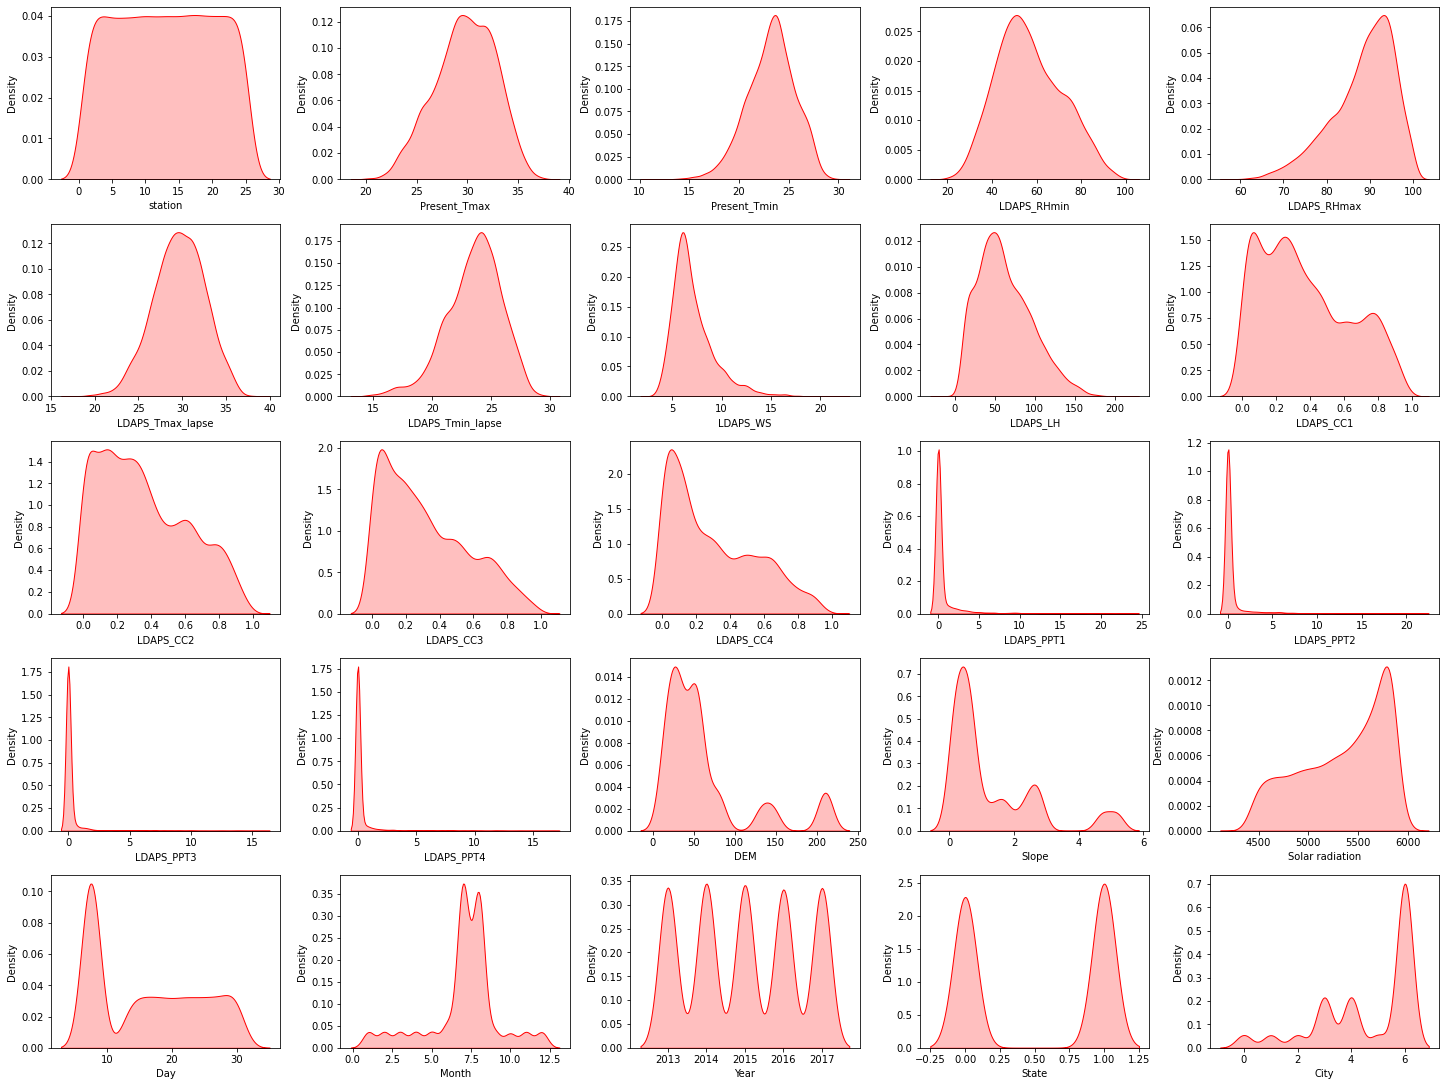

In [30]:
fig, ax=plt.subplots(ncols=5,nrows=5, figsize=(20,15))
index=0
ax=ax.flatten()
for col, values in df[feature_columns].items():
    sns.distplot(values, ax=ax[index], hist=False, color='r', kde_kws={'shade':True})
    index += 1
    
plt.tight_layout(pad=.4, w_pad=.4, h_pad=1)
plt.show()

# Using Zscore to ramove the outliers

In [31]:
z = np.abs(zscore(df))
threshold = 3
df1 = df[(z<3).all(axis = 1)]
loss=(df.shape[0]-df1.shape[0])/df.shape[0]*100
loss

11.188719030047443

After using zscore to remove outlier our datasets lost his 11.18% data that is something huge but since we have huge number of rows we can afford this loss.

In [32]:
df=df1.copy()

# Using Log Transform to fix skewness

In [33]:
for col in feature_columns:
    if df.skew().loc[col]>.55:
        df[col]=np.log1p(df[col])

In [34]:
df.skew()

station            -0.001594
Present_Tmax       -0.269936
Present_Tmin       -0.221250
LDAPS_RHmin         0.309567
LDAPS_RHmax        -0.686083
LDAPS_Tmax_lapse   -0.110563
LDAPS_Tmin_lapse   -0.379269
LDAPS_WS            0.473278
LDAPS_LH           -0.616039
LDAPS_CC1           0.329077
LDAPS_CC2           0.505774
LDAPS_CC3           0.440898
LDAPS_CC4           0.495420
LDAPS_PPT1          2.745464
LDAPS_PPT2          3.637804
LDAPS_PPT3          4.231731
LDAPS_PPT4          4.602734
DEM                 0.450739
Slope               0.845591
Solar radiation    -0.520157
Next_Tmax          -0.267526
Next_Tmin          -0.234328
Day                 0.256528
Month              -0.680725
Year                0.025066
State              -0.073965
City               -0.968512
dtype: float64

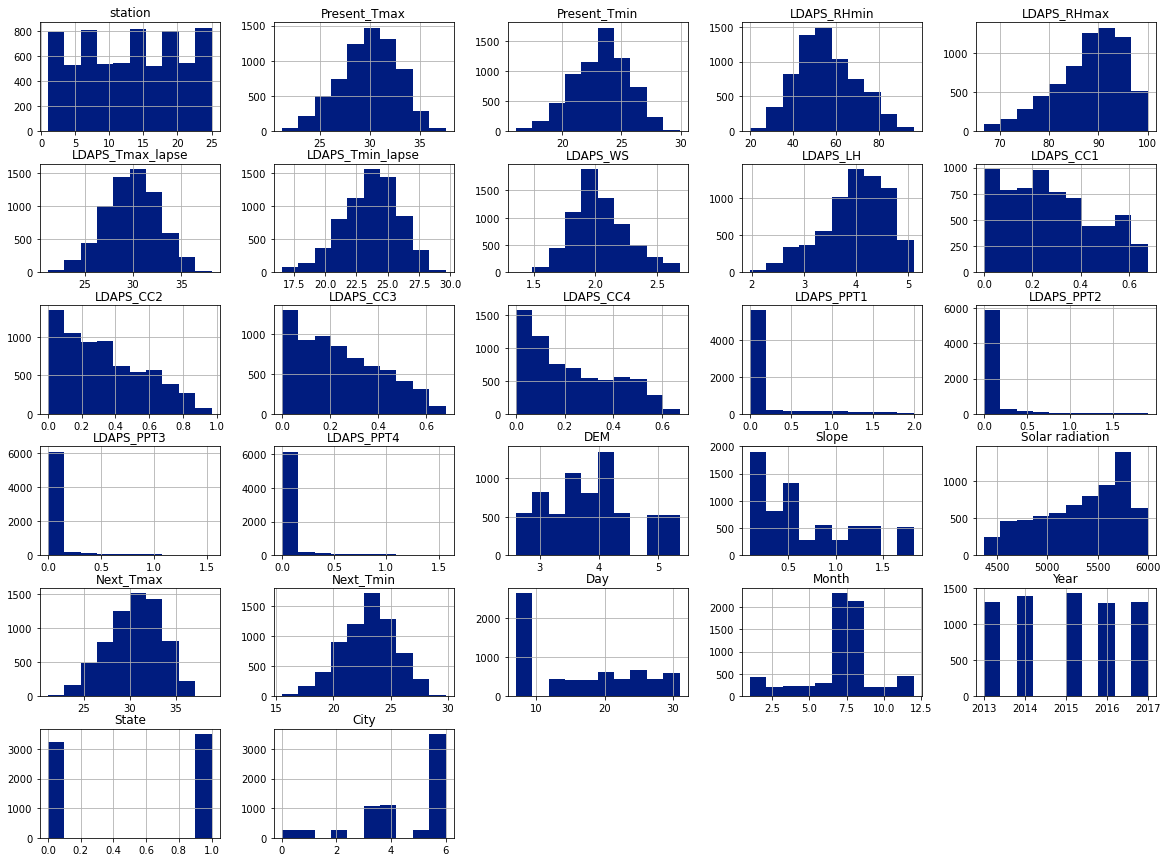

In [35]:
df.hist(figsize=(20,15))
plt.show()

# Correlation using a Heatmap
Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.
                                                                                       Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

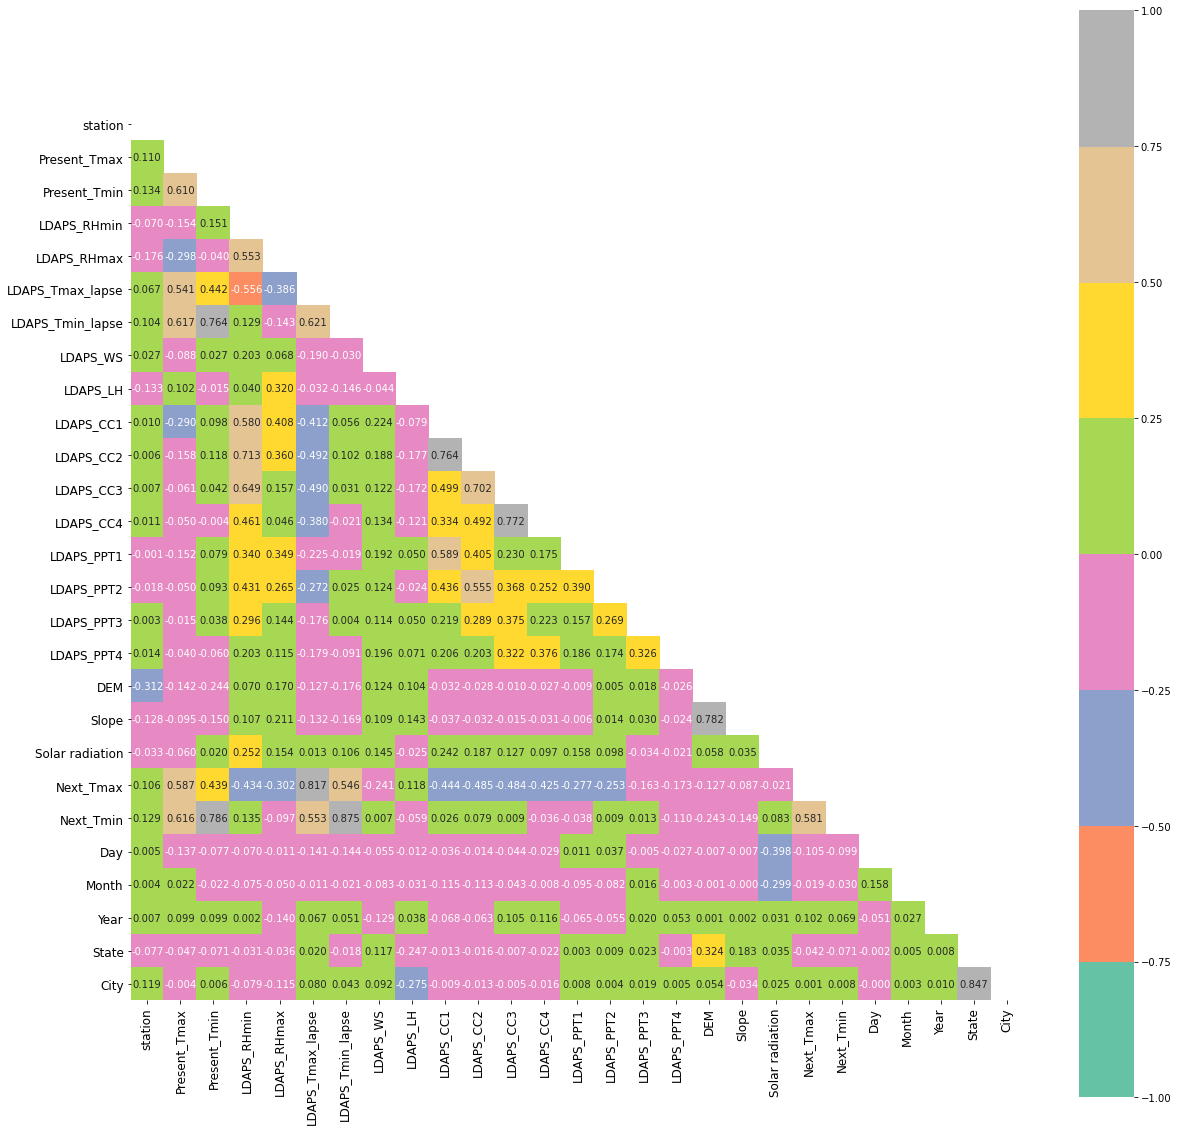

In [36]:
plt.style.use('seaborn-pastel')
upper_triangle=np.triu(df.corr())
figure=plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),vmin=-1,vmax=1, annot=True, square=True, fmt='.3f',annot_kws={'size':10},cmap='Set2',mask=upper_triangle)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

from the above heatmap method we can see that there some columns showing multicollinearity but these columns are important for our label prediction so we cant drop it . 

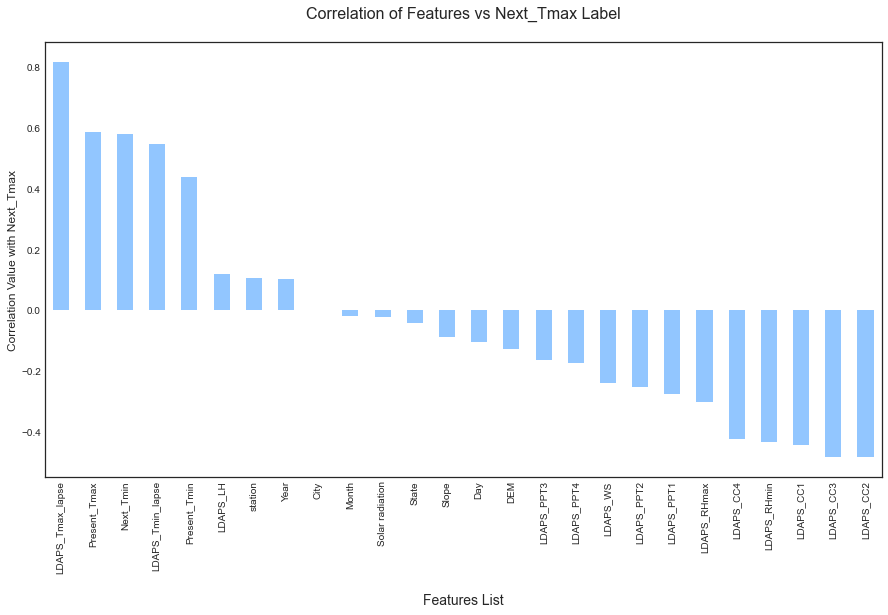

In [37]:
plt.style.use('seaborn-white')

df_corr = df.corr()
plt.figure(figsize=(15,8))
df_corr[label_columns[0]].sort_values(ascending=False).drop(label_columns[0]).plot.bar()
plt.title("Correlation of Features vs Next_Tmax Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value with Next_Tmax", fontsize=12)
plt.show()

since heatmap is not very clear so we have used this bar method and we can see here more than half of the columns are negatively related to label and less than half is related possitevly.

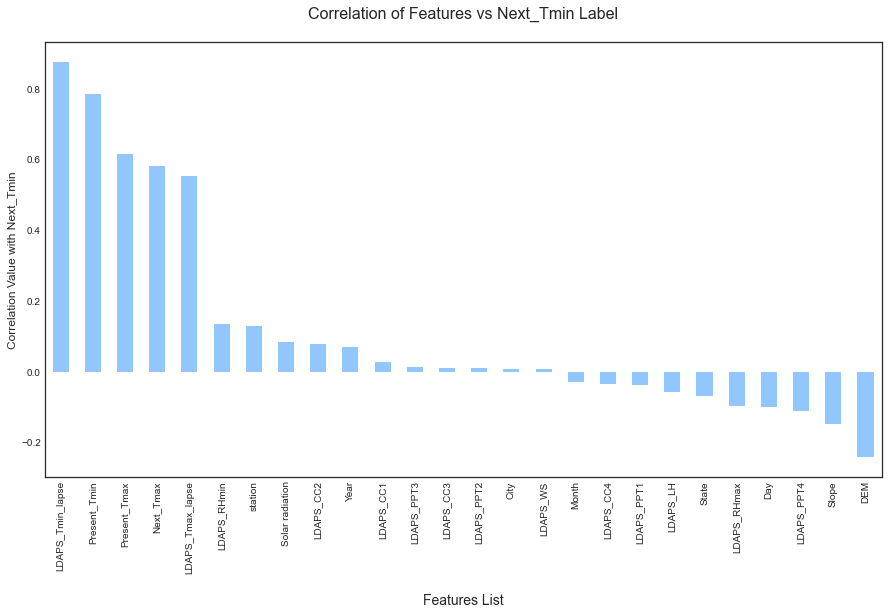

In [38]:
plt.style.use('seaborn-white')

df_corr = df.corr()
plt.figure(figsize=(15,8))
df_corr[label_columns[1]].sort_values(ascending=False).drop(label_columns[1]).plot.bar()
plt.title("Correlation of Features vs Next_Tmin Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value with Next_Tmin", fontsize=12)
plt.show()

since heatmap is not very clear so we have used this bar method and we can see here more than half of the columns are negatively related to label and less than half is related possitevly.

# Splitting whole the dataset into two parts namely X, Y

In [39]:
X=df.drop('Next_Tmax', axis=1)
Y=df['Next_Tmax']
Y

0       29.1
1       30.5
2       31.1
3       31.7
4       31.2
        ... 
7745    27.6
7746    28.0
7747    28.3
7748    28.6
7749    27.8
Name: Next_Tmax, Length: 6739, dtype: float64

In [40]:
X.isnull().sum()

station             0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            1
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmin           0
Day                 0
Month               0
Year                0
State               0
City                0
dtype: int64

In [41]:
X['LDAPS_LH']=X['LDAPS_LH'].fillna(X['LDAPS_LH']).mean()

# Feature Scaling

In [42]:
scaler=StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT4,DEM,Slope,Solar radiation,Next_Tmin,Day,Month,Year,State,City
0,-1.672719,-0.425704,-0.814460,0.195915,0.437537,-0.662498,-0.289928,0.092116,0.0,-0.379923,...,-0.27701,2.091329,1.330799,1.543068,-0.790587,1.674045,-0.479519,-1.421473,0.963709,0.815820
1,-1.533959,0.690215,-0.727785,-0.236604,0.364239,-0.016693,0.171379,-0.612887,0.0,-0.417662,...,-0.27701,-0.026415,-0.502169,1.249502,-0.239151,1.674045,-0.479519,-1.421473,0.963709,0.815820
2,-1.395198,0.585598,0.008945,-0.494494,-0.585732,0.070769,0.409475,-0.320426,0.0,-0.490678,...,-0.27701,-0.422779,-0.860029,1.235827,0.354704,1.674045,-0.479519,-1.421473,0.963709,0.815820
3,-1.256438,0.725088,0.052282,0.194767,1.206456,-0.069787,-0.146681,-0.641296,0.0,-0.458811,...,-0.27701,0.001957,1.193982,1.220170,0.524376,1.674045,-0.479519,-1.421473,0.963709,0.815820
4,-1.117678,0.515853,-0.597774,0.045667,0.299831,-0.284509,-0.074752,-0.583798,0.0,-0.760645,...,-0.27701,-0.355053,-0.513564,1.226317,-0.239151,1.674045,-0.479519,-1.421473,-1.037658,-0.886113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6734,1.102482,-2.378563,-2.374595,-2.226900,-1.404059,-0.757521,-2.400625,-0.034556,0.0,-1.252451,...,-0.27701,-0.737167,-0.426965,-2.107693,-2.275223,1.674045,0.410206,1.442938,0.963709,0.815820
6735,1.241243,-2.587798,-2.547943,-1.836710,-0.626356,-1.160213,-2.620034,-0.561605,0.0,-1.182088,...,-0.27701,-0.974837,-1.081884,-2.141474,-2.529732,1.674045,0.410206,1.442938,-1.037658,0.248509
6736,1.380003,-2.308818,-2.677955,-2.078766,-1.316889,-1.288468,-2.188536,-0.313645,0.0,-1.373202,...,-0.27701,-1.422480,-1.043071,-2.137886,-2.105550,1.674045,0.410206,1.442938,-1.037658,-0.318802
6737,1.518763,-2.308818,-2.417932,-2.273699,-1.542506,-1.049238,-2.207453,-0.070703,0.0,-1.342114,...,-0.27701,-1.287655,-0.930463,-2.149622,-1.808623,1.674045,0.410206,1.442938,-1.037658,-0.318802


# Finding Best Random State for building best Regression ML model

In [43]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LinearRegression()
    lr.fit(X_train,Y_train)
    pred = lr.predict(X_test)
    r2 = r2_score(Y_test, pred)*100
    
    if r2>maxAccu:
        maxAccu=r2
        maxRS=i

print("Best R2 score is", maxAccu,"on Random State", maxRS)

Best R2 score is 80.66974998114614 on Random State 815


# Feature Importance

In [44]:
rf=RandomForestRegressor()
rf.fit(X_train, Y_train)
importances = pd.DataFrame({'Features':X.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances

,Importance
Features,
LDAPS_Tmax_lapse,0.645
Present_Tmax,0.062
Next_Tmin,0.037
LDAPS_CC1,0.033
LDAPS_CC3,0.029
LDAPS_CC4,0.029
LDAPS_WS,0.022
LDAPS_CC2,0.016
Solar radiation,0.015


Machine learning Model for Regression Model with Evalution metrics

In [45]:
def reg(model,X,Y):
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=.25, random_state=815)
    
    #model Training
    model.fit(X_train,Y_train)
    
    #predicting Y_test
    pred=model.predict(X_test)
    
    # RMSE - a lower RMSE score is better than a higher one
    rmse = mean_squared_error(Y_test, pred, squared=False)
    print("RMSE Score is:", rmse)
    
    # R2 score
    r2 = r2_score(Y_test, pred, multioutput='variance_weighted')*100
    print("R2 Score is:", r2)
    
    #cross val score
    cv_score=(cross_val_score(model,X,Y,cv=5).mean())*100
    print('cross val score =', cv_score)
    
    #REsult
    result=r2-cv_score
    print('r2_score - cv_score =', result)

In [46]:
#LInearRegression
model=LinearRegression()
reg(model,X,Y)

RMSE Score is: 1.3075843031988956
R2 Score is: 80.66974998114614
cross val score = 68.97822249118177
r2_score - cv_score = 11.691527489964372


In [47]:
#Ridge
model=Ridge()
reg(model,X,Y)

RMSE Score is: 1.3076050861278077
R2 Score is: 80.66913550083514
cross val score = 68.98303317265866
r2_score - cv_score = 11.686102328176474


In [55]:
# Lasso
model=Lasso()
reg(model,X,Y)

RMSE Score is: 1.9994556602807663
R2 Score is: 54.801748988108216
cross val score = 49.66272403537687
r2_score - cv_score = 5.139024952731347


In [49]:
#DecisionTree Regressor
model=DecisionTreeRegressor()
reg(model,X,Y)

RMSE Score is: 1.2380538954630436
R2 Score is: 82.67085338005326
cross val score = 42.17520372470145
r2_score - cv_score = 40.49564965535181


In [50]:
model=RandomForestRegressor(max_depth=2, max_features="sqrt")
reg(model, X, Y)

RMSE Score is: 1.8548252564934842
R2 Score is: 61.10407750721504
cross val score = 48.862358735198825
r2_score - cv_score = 12.241718772016213


In [51]:
# K Neighbors Regressor

model=KNeighborsRegressor(n_neighbors=2, algorithm='kd_tree')
reg(model, X, Y)

RMSE Score is: 1.0816118864902662
R2 Score is: 86.77362057965674
cross val score = 43.09614550549673
r2_score - cv_score = 43.67747507416001


In [52]:
# Extra Trees Regressor

model=ExtraTreesRegressor(n_estimators=200, max_features='sqrt', n_jobs=6)
reg(model, X, Y)

RMSE Score is: 0.7918199347158132
R2 Score is: 92.9115556060248
cross val score = 67.12618488530678
r2_score - cv_score = 25.78537072071802


# Hyper parameter tuning upon our best Regression Ml model

In [56]:
#Ridge for hypertuning
params={'alpha':[1,2,3,4,5],'fit_intercept':[True,False],'normalize':[True,False],'solver':['auto','svd','saga','sparse_cg']}

In [60]:
GSCV=GridSearchCV(Ridge(),params, cv=5)

In [61]:
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1, 2, 3, 4, 5],
                         'fit_intercept': [True, False],
                         'normalize': [True, False],
                         'solver': ['auto', 'svd', 'saga', 'sparse_cg']})

In [62]:
GSCV.best_score_

0.7775501802424009

In [63]:
GSCV.best_params_

{'alpha': 3, 'fit_intercept': True, 'normalize': False, 'solver': 'saga'}

In [66]:
Final_Model=Ridge(alpha=3, fit_intercept=True, normalize=False, solver='saga')
Final_Model.fit(X_train,Y_train)
pred=Final_Model.predict(X_test)
r2_score=r2_score(pred,Y_test)*100
print('r2 score is ',r2_score)

r2 score is  71.5886127840268


# Save the Model

In [67]:
Filename='final_model_10'
joblib.dump(Final_Model,Filename)

['final_model_10']

# Thanks